In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

climate_input_path = "../data/climate"
merge_input_path = "../data/merge"
reference_grid = "../data/climate/month/era5_ice/01.nc"
years = list(range(1991, 2020))

ds = xr.open_dataset(reference_grid, engine="h5netcdf")
lat, lon = ds.lat.values, ds.lon.values

def distribution(period, inmcm_anomaly_path, era5_anomaly_path, variable, era5_variable):
    anomalies = []
    era5_anomalies = []
    for year in tqdm(years):
        input_file = f"{inmcm_anomaly_path}/{year}{period:02d}.nc"
        if not os.path.exists(input_file):
            print(f"Not found {input_file}")
            continue
        ds = xr.open_dataset(input_file, engine="h5netcdf")
        if len(ds.variables) == 0:
            continue
        anomaly = ds.interp(lat=lat, lon=lon)[variable].values
        input_file = f"{era5_anomaly_path}/{year}{period:02d}.nc"
        if not os.path.exists(input_file):
            print(f"Not found {input_file}")
            continue
        for i in range(anomaly.shape[0]):
            anomalies.append(anomaly[i, :, :])
        era5_anomalies.append(xr.open_dataset(input_file, engine="h5netcdf")[era5_variable].values)
    anomalies, era5_anomalies = np.array(anomalies, dtype=np.float32), np.array(era5_anomalies, dtype=np.float32)
    return anomalies, era5_anomalies

def read_climate(variable, period, path):
    if not os.path.exists(path):
        print(f'File {path} not found')
        return np.array([])

    ds = xr.open_dataset(path, engine="h5netcdf").interp(lat=lat, lon=lon)
    return ds[variable].values

def mae(x, y):
    mask = (~np.isnan(x)) & (~np.isnan(y)) & ((x != 0) | (y != 0))
    return np.mean(np.abs(x[mask]-y[mask]))

In [2]:
a, b = distribution(1, f'{merge_input_path}/inmcm_ice', f'{merge_input_path}/era5_ice', 'aice', 'ice')

  0%|          | 0/29 [00:00<?, ?it/s]

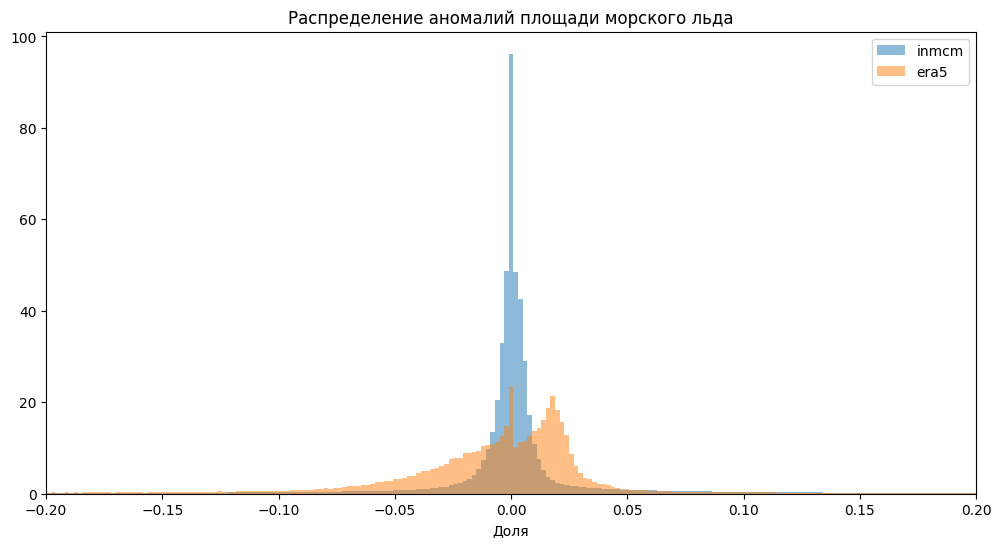

In [3]:
a0, b0 = a.ravel(), b.ravel()
plt.figure(figsize=(12, 6))
plt.hist(a0[(a0 != 0) & (np.abs(a0) < 0.2)], 201, density=True, alpha=0.5)
plt.hist(b0[(b0 != 0) & (np.abs(b0) < 0.2)], 201, density=True, alpha=0.5)
plt.xlim([-0.2, 0.2])
plt.title('Распределение аномалий площади морского льда')
plt.xlabel('Доля')
plt.legend(['inmcm', 'era5'])
plt.show()

In [4]:
a, b = distribution(1, f'{merge_input_path}/inmcm_swe', f'{merge_input_path}/era5_swe', 'swe', 'swe')

  0%|          | 0/29 [00:00<?, ?it/s]

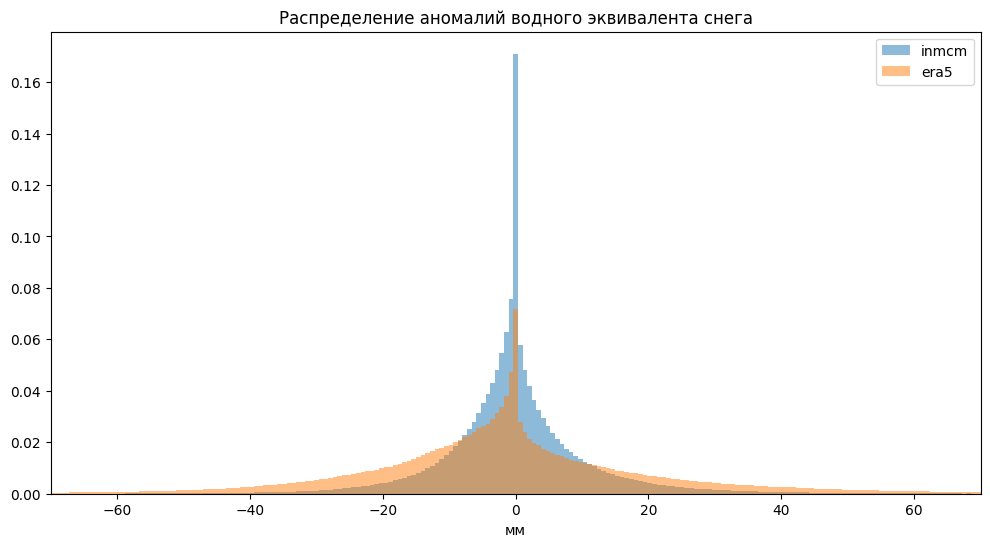

In [5]:
a0, b0 = a.ravel(), b.ravel()
plt.figure(figsize=(12, 6))
plt.hist(a0[(a0 != 0) & (np.abs(a0) < 70)], 201, density=True, alpha=0.5)
plt.hist(b0[(b0 != 0) & (np.abs(b0) < 70)], 201, density=True, alpha=0.5)
plt.xlim([-70, 70])
plt.title('Распределение аномалий водного эквивалента снега')
plt.xlabel('мм')
plt.legend(['inmcm', 'era5'])
plt.show()

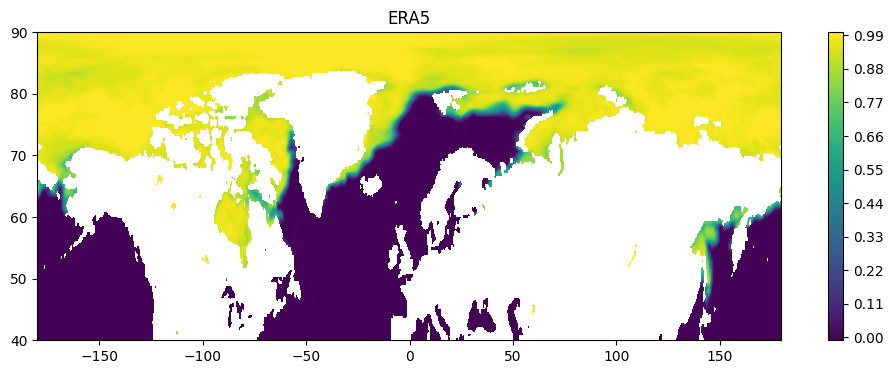

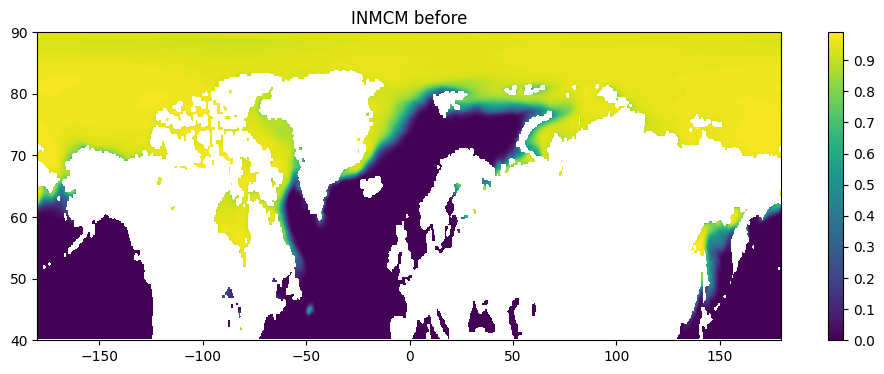

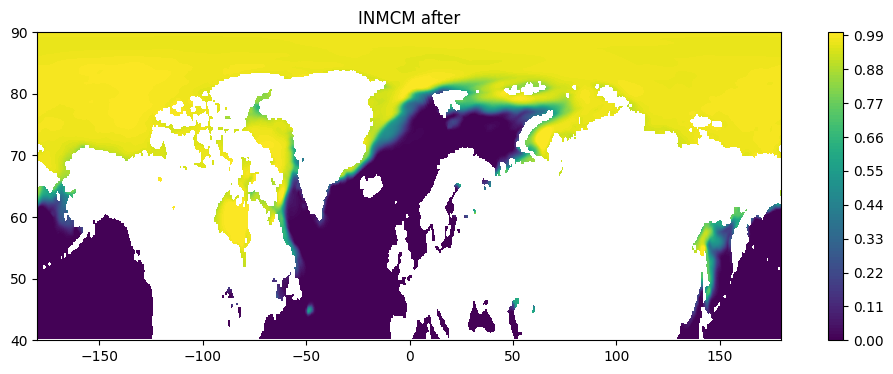

BEFORE 0.054
AFTER 0.044
CLIMATE 0.046


In [10]:
month = 1
inmcm_climate = read_climate('aice', month, f'{climate_input_path}/month/aice/{month:02d}.nc')
era5_climate = read_climate('ice', month, f'{climate_input_path}/month/era5_ice/{month:02d}.nc')
inmcm_anom = xr.open_dataset('../data/merge/inmcm_ice/200001.nc', engine="h5netcdf").sel(lead_time=0).interp(lat=lat, lon=lon).aice.values
era5_anom = xr.open_dataset('../data/merge/era5_ice/200001.nc', engine="h5netcdf").ice.values
inmcm_corrected_anom = xr.open_dataset('../data/corrected/aice/result/200001.nc', engine="h5netcdf").sel(lead_time=0).aice.values

plt.figure(figsize=(12, 4))
plt.title("ERA5")
plt.contourf(lon, lat, era5_anom + era5_climate, 101)
plt.colorbar()
plt.show()
plt.figure(figsize=(12, 4))
plt.title("INMCM before")
plt.contourf(lon, lat, inmcm_anom + inmcm_climate, 101)
plt.colorbar()
plt.show()
plt.figure(figsize=(12, 4))
plt.title("INMCM after")
plt.contourf(lon, lat, inmcm_corrected_anom + era5_climate, 101)
plt.colorbar()
plt.show()

print('BEFORE', np.round(mae(era5_anom + era5_climate, inmcm_anom + inmcm_climate), 3))
print('AFTER', np.round(mae(era5_anom + era5_climate, inmcm_corrected_anom + era5_climate), 3))
print('CLIMATE', np.round(mae(era5_anom + era5_climate, era5_climate), 3))

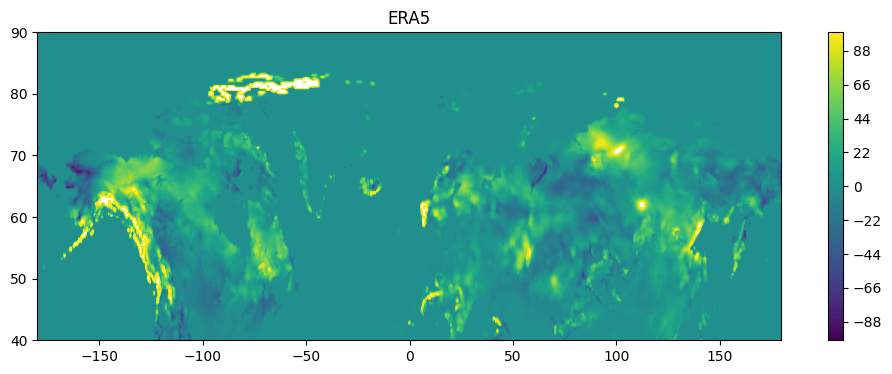

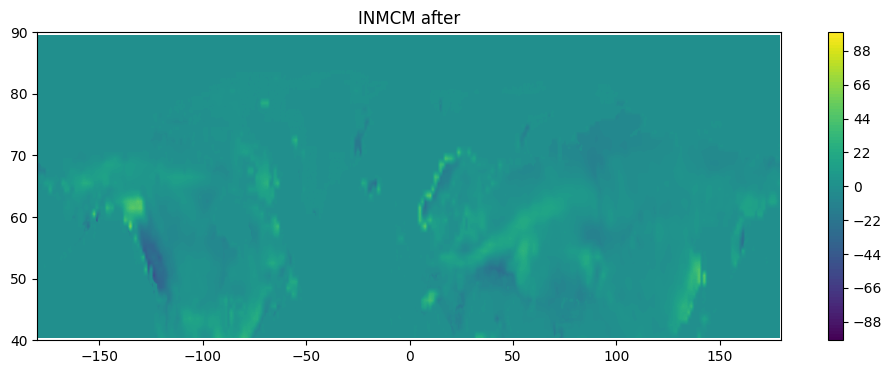

BEFORE 37.415
AFTER 19.663
CLIMATE 18.288


In [14]:
week = 1
inmcm_climate = read_climate('swe', week, f'{climate_input_path}/week/swe/{week:02d}.nc')
era5_climate = read_climate('swe', week, f'{climate_input_path}/week/era5_swe/{week:02d}.nc')
inmcm_anom = xr.open_dataset('../data/merge/inmcm_swe/200001.nc', engine="h5netcdf").sel(lead_time=0).interp(lat=lat, lon=lon).swe.values
era5_anom = xr.open_dataset('../data/merge/era5_swe/200001.nc', engine="h5netcdf").swe.values
inmcm_corrected_anom = xr.open_dataset('../data/corrected/swe/result/200001.nc', engine="h5netcdf").sel(lead_time=0).swe.values

era5_climate[np.abs(era5_climate) > 300] = np.nan
era5_climate[era5_climate == 0] = np.nan

plt.figure(figsize=(12, 4))
plt.title("ERA5")
plt.contourf(lon, lat, era5_anom, np.linspace(-100, 100, 101))
plt.colorbar()
plt.show()
plt.figure(figsize=(12, 4))
plt.title("INMCM after")
plt.contourf(lon, lat, inmcm_corrected_anom, np.linspace(-100, 100, 101))
plt.colorbar()
plt.show()

print('BEFORE', np.round(mae(era5_anom + era5_climate, inmcm_anom + inmcm_climate), 3))
print('AFTER', np.round(mae(era5_anom + era5_climate, inmcm_corrected_anom + era5_climate), 3))
print('CLIMATE', np.round(mae(era5_anom + era5_climate, era5_climate), 3))

In [8]:
ds = xr.open_dataset('../data/corrected/swe/result/200340.nc', engine="h5netcdf")
ds

<xarray.Dataset> Size: 74MB
Dimensions:    (lead_time: 4, lat: 201, lon: 1440)
Coordinates:
  * lead_time  (lead_time) int64 32B 0 1 2 3
  * lat        (lat) float32 804B 40.0 40.25 40.5 40.75 ... 89.5 89.75 90.0
  * lon        (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables: (12/16)
    swe        (lead_time, lat, lon) float32 5MB ...
    cld        (lead_time, lat, lon) float32 5MB ...
    h500       (lead_time, lat, lon) float32 5MB ...
    olr        (lead_time, lat, lon) float32 5MB ...
    prec       (lead_time, lat, lon) float32 5MB ...
    ps         (lead_time, lat, lon) float32 5MB ...
    ...         ...
    t850       (lead_time, lat, lon) float32 5MB ...
    u850       (lead_time, lat, lon) float32 5MB ...
    uv10       (lead_time, lat, lon) float32 5MB ...
    v850       (lead_time, lat, lon) float32 5MB ...
    ws         (lead_time, lat, lon) float32 5MB ...
    ww         (lead_time, lat, lon) float32 5MB ...

In [9]:
ds = xr.open_dataset('../data/corrected/aice/result/200002.nc', engine="h5netcdf")
ds

<xarray.Dataset> Size: 74MB
Dimensions:    (lead_time: 4, lat: 201, lon: 1440)
Coordinates:
  * lead_time  (lead_time) int64 32B 0 1 2 3
  * lat        (lat) float32 804B 40.0 40.25 40.5 40.75 ... 89.5 89.75 90.0
  * lon        (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
Data variables: (12/16)
    aice       (lead_time, lat, lon) float32 5MB ...
    hice       (lead_time, lat, lon) float32 5MB ...
    sst        (lead_time, lat, lon) float32 5MB ...
    cld        (lead_time, lat, lon) float32 5MB ...
    h500       (lead_time, lat, lon) float32 5MB ...
    olr        (lead_time, lat, lon) float32 5MB ...
    ...         ...
    t2max      (lead_time, lat, lon) float32 5MB ...
    t2min      (lead_time, lat, lon) float32 5MB ...
    t850       (lead_time, lat, lon) float32 5MB ...
    u850       (lead_time, lat, lon) float32 5MB ...
    uv10       (lead_time, lat, lon) float32 5MB ...
    v850       (lead_time, lat, lon) float32 5MB ...